In [1]:
from pathlib import Path
import pickle

In [2]:
import numpy as np
import pandas as pd

In [3]:
import gpflow
import tensorflow as tf

In [4]:
from gpflow.utilities import print_summary
gpflow.config.set_default_summary_fmt("notebook")

In [5]:
import casadi as cs

In [6]:
import matplotlib.pyplot as plt

In [7]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (20, 6)

## GP model

In [8]:
size = 500

In [9]:
X = np.linspace(-25, 25, num = size)
# x^4 + 3*sin(x)
Y =3 * np.sin(X)

In [10]:
df_func = pd.DataFrame({
    'X': X,
    'Y': Y
})

In [11]:
n_sampl = 50

In [12]:
df_sampled = df_func.sample(n_sampl)
X_sampled = df_sampled['X'].to_numpy().reshape(-1, 1)

In [13]:
Y_sampled = df_sampled['Y'].to_numpy().reshape(-1, 1)

# Add noise to the output
mean, var = 0, 0.25
noise = np.random.normal(mean, var, size = Y_sampled.shape)

Y_sampled = Y_sampled + noise

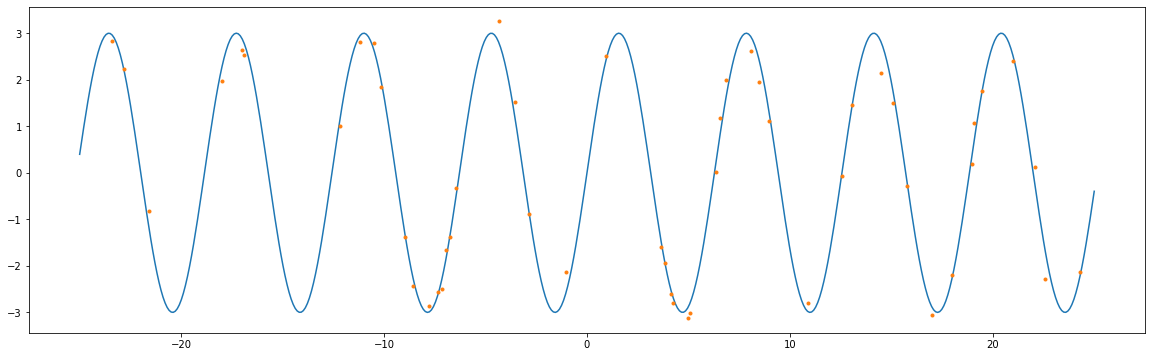

In [14]:
plt.figure()
plt.plot(X, Y)
plt.plot(X_sampled, Y_sampled, '.')
plt.show()

In [15]:
k = gpflow.kernels.SquaredExponential() + gpflow.kernels.Linear()

In [16]:
print_summary(k)

name,class,transform,prior,trainable,shape,dtype,value
Sum.kernels[0].variance,Parameter,Softplus,,True,(),float64,1
Sum.kernels[0].lengthscales,Parameter,Softplus,,True,(),float64,1
Sum.kernels[1].variance,Parameter,Softplus,,True,(),float64,1


In [17]:
model = gpflow.models.GPR(
    data = (X_sampled, Y_sampled), 
    kernel = k, 
    mean_function = None
    )
print_summary(model)

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.kernels[0].variance,Parameter,Softplus,,True,(),float64,1
GPR.kernel.kernels[0].lengthscales,Parameter,Softplus,,True,(),float64,1
GPR.kernel.kernels[1].variance,Parameter,Softplus,,True,(),float64,1
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1


In [18]:
opt = gpflow.optimizers.Scipy()
opt_logs = opt.minimize(model.training_loss, model.trainable_variables, options=dict(maxiter=1000))
print_summary(model)

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.kernels[0].variance,Parameter,Softplus,,True,(),float64,6.18044
GPR.kernel.kernels[0].lengthscales,Parameter,Softplus,,True,(),float64,1.50932
GPR.kernel.kernels[1].variance,Parameter,Softplus,,True,(),float64,1.33892e-08
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.0456394


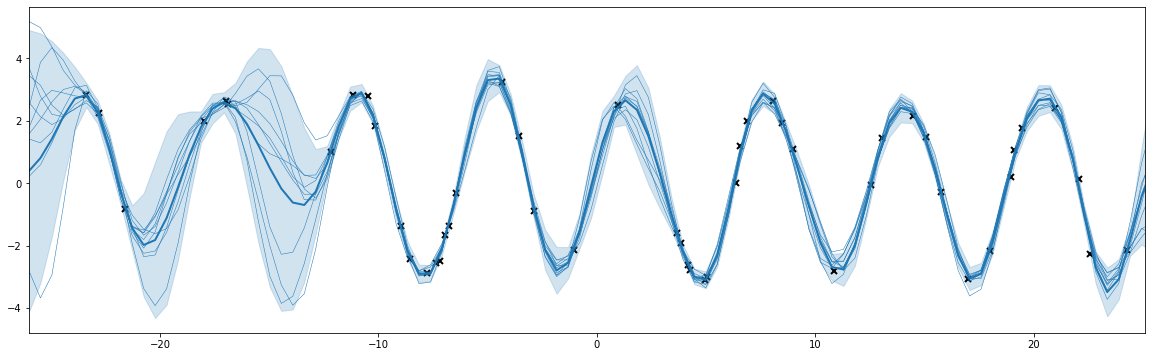

In [19]:
## generate test points for prediction
xx = np.linspace(-26, 26, 100).reshape(100, 1)  # test points must be of shape (N, D)

## predict mean and variance of latent GP at test points
mean, var = model.predict_f(xx)

## generate 10 samples from posterior
tf.random.set_seed(1)  # for reproducibility
samples = model.predict_f_samples(xx, 10)  # shape (10, 100, 1)

## plot
plt.figure()
plt.plot(X_sampled, Y_sampled, "kx", mew=2)
plt.plot(xx, mean, "C0", lw=2)
plt.fill_between(
    xx[:, 0],
    mean[:, 0] - 1.96 * np.sqrt(var[:, 0]),
    mean[:, 0] + 1.96 * np.sqrt(var[:, 0]),
    color="C0",
    alpha=0.2,
)
plt.plot(xx, samples[:, :, 0].numpy().T, "C0", linewidth=0.5)
#plt.plot(X, Y, color = 'darkorange', lw = 2)
_ = plt.xlim(-26, 25.1)

## CasADi part

In [20]:
# Package the resulting regression model in a CasADi callback
class GPR(cs.Callback):
  def __init__(self, name,  opts={}):
    cs.Callback.__init__(self)
    self.construct(name, opts)

  def eval(self, arg):
    [mean, _] = model.predict_y(np.array(arg[0]))
    return [mean.numpy()]

In [21]:
# Instantiate the Callback (make sure to keep a reference to it!)
gpr = GPR('GPR', {"enable_fd":True})
print(gpr)

GPR:(i0)->(o0) CallbackInternal


In [28]:
x = cs.MX.sym("x")
y = cs.MX.sym("y")

In [34]:
y = 2 * gpr(x) + 5

In [35]:
y

MX((5+(2.*GPR(x){0})))

In [27]:
# Find the minimum of the regression model
x = cs.MX.sym("x")
y = cs.MX.sym("y")


solver = cs.nlpsol("solver","ipopt",{"x":x,"f":gpr(x)})
res = solver(x0=5)

This is Ipopt version 3.13.4, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        1

Total number of variables............................:        1
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 -

In [23]:
res['x']

DM(4.79658)

In [24]:
opti = cs.Opti()

x = opti.variable()

f = gpr(x)
#f = (2.6-x)**2+(y-x**2)**2

opti.minimize(f)

opti.solver('ipopt')

sol = opti.solve()

print(sol.value(x))

This is Ipopt version 3.13.4, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        1

Total number of variables............................:        1
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

In [25]:
sol.value(f)

-0.7259694543457814

In [26]:
sol.value(x)

-13.561827666614862